In [ ]:
!apt-get update
!apt-get install sox libsox-dev libsox-fmt-all -y
!pip install torchaudio librosa matplotlib seaborn scikit-learn tensorboard

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (117 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import librosa
import librosa.display
import itertools
from IPython.display import Audio, display
from torchvision import models
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)


Using device: cpu


In [ ]:
librispeech_dataset = torchaudio.datasets.LIBRISPEECH(".", url="train-clean-100", download=True)
sample_waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = librispeech_dataset[0]
print(f"Sample Rate: {sample_rate}")
print(f"Speaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}")
print(f"Transcript: {utterance}")
print(f"Waveform shape: {sample_waveform.shape}")

def play_audio(waveform, sample_rate):
    display(Audio(waveform.numpy(), rate=sample_rate))

play_audio(sample_waveform, sample_rate)



Sample Rate: 16000
Speaker ID: 103, Chapter ID: 1240, Utterance ID: 0
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Waveform shape: torch.Size([1, 225360])


In [ ]:

import torchaudio
import torch.nn.functional as F

# Define MFCC transform
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40,
    melkwargs={
        'n_fft': 400,
        'n_mels': 40,
        'hop_length': 160,
        'mel_scale': 'htk',
    }
)

# Corrected Vad transform initialization with sample_rate
vad_transform = torchaudio.transforms.Vad(
    sample_rate=16000,      # Required positional argument
    trigger_level=0.5        # Adjust as needed
    # Removed unsupported parameters: padding_ms and transition_ms
)

def preprocess_waveform(waveform, sample_rate):
    """
    Preprocesses the waveform by applying VAD, resampling, and ensuring mono channel.
    """
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    try:
        vad_waveform = vad_transform(waveform)
    except Exception as e:
        print(f"VAD failed for waveform: {e}")
        vad_waveform = waveform
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        vad_waveform = resampler(vad_waveform)
    if vad_waveform.size(0) > 1:
        vad_waveform = vad_waveform.mean(dim=0, keepdim=True)
    if vad_waveform.size(1) == 0:
        print("Warning: VAD removed all audio. Using original waveform.")
        vad_waveform = waveform
    return vad_waveform

def augment_waveform(waveform, sample_rate):
    """
    Applies random augmentations to the waveform for data augmentation.
    """
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    effects = []
    if random.random() < 0.5:
        speed_factor = np.random.uniform(0.9, 1.1)
        effects.extend(['speed', f'{speed_factor}', 'rate', f'{sample_rate}'])
    if random.random() < 0.5:
        pitch_shift = np.random.uniform(-2, 2)
        cents = pitch_shift * 100
        effects.extend(['pitch', f'{cents}', 'rate', f'{sample_rate}'])
    if random.random() < 0.5:
        effects.extend(['reverb', '-w'])
    if effects:
        try:
            waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sample_rate, effects)
            if waveform.size(0) > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
        except Exception as e:
            print(f"Augmentation failed: {e}")
            pass
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if waveform.size(1) == 0:
        print("Warning: Augmentation resulted in empty waveform. Using original waveform.")
        waveform = waveform
    return waveform

def get_mfcc(waveform, fixed_length=500):
    """
    Computes the MFCC features from the waveform and ensures a fixed length.
    """
    if waveform.size(0) > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    mfcc = mfcc_transform(waveform)
    mfcc = mfcc.squeeze(0)
    mfcc = (mfcc - mfcc.mean(dim=1, keepdim=True)) / (mfcc.std(dim=1, keepdim=True) + 1e-6)
    current_length = mfcc.size(1)
    if current_length < fixed_length:
        pad_amount = fixed_length - current_length
        mfcc = F.pad(mfcc, (0, pad_amount))
    else:
        mfcc = mfcc[:, :fixed_length]
    return mfcc


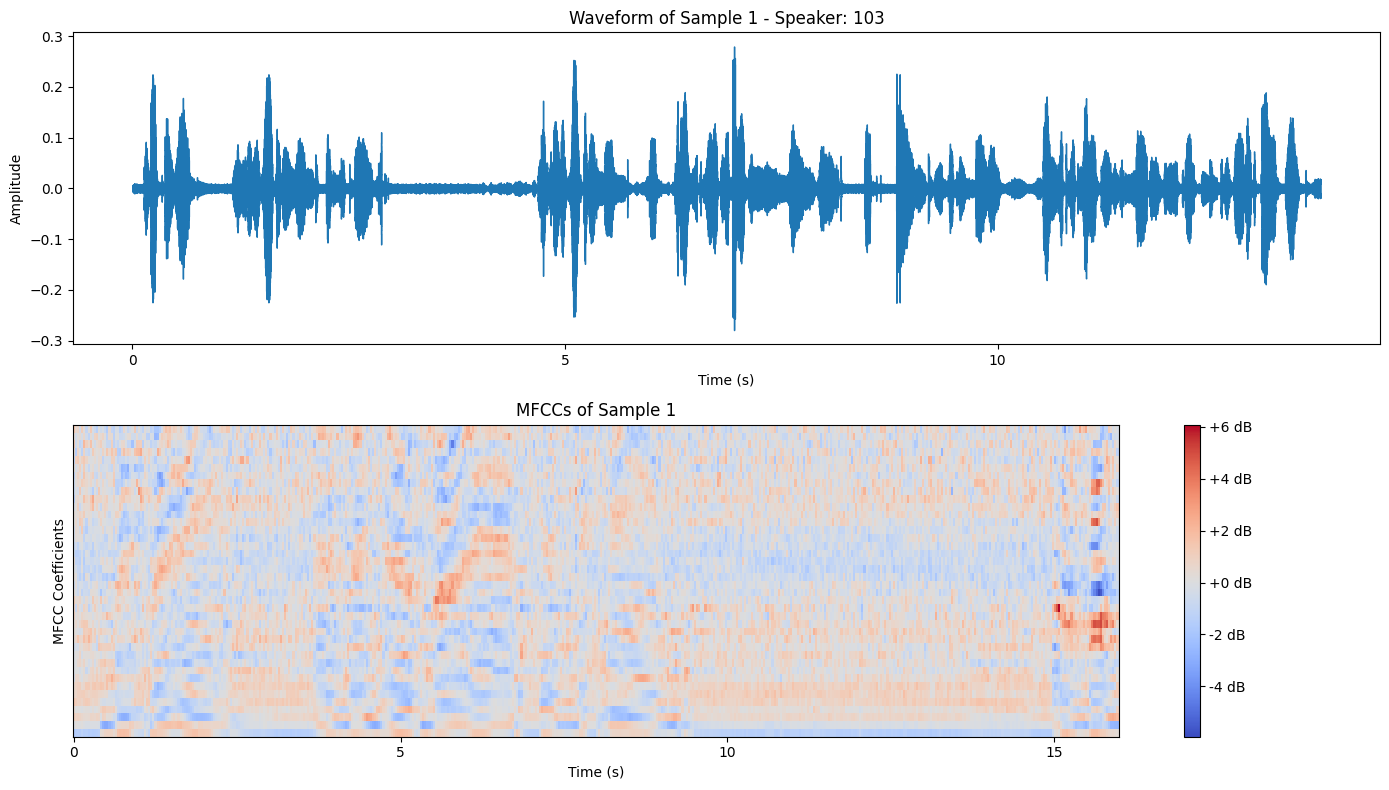

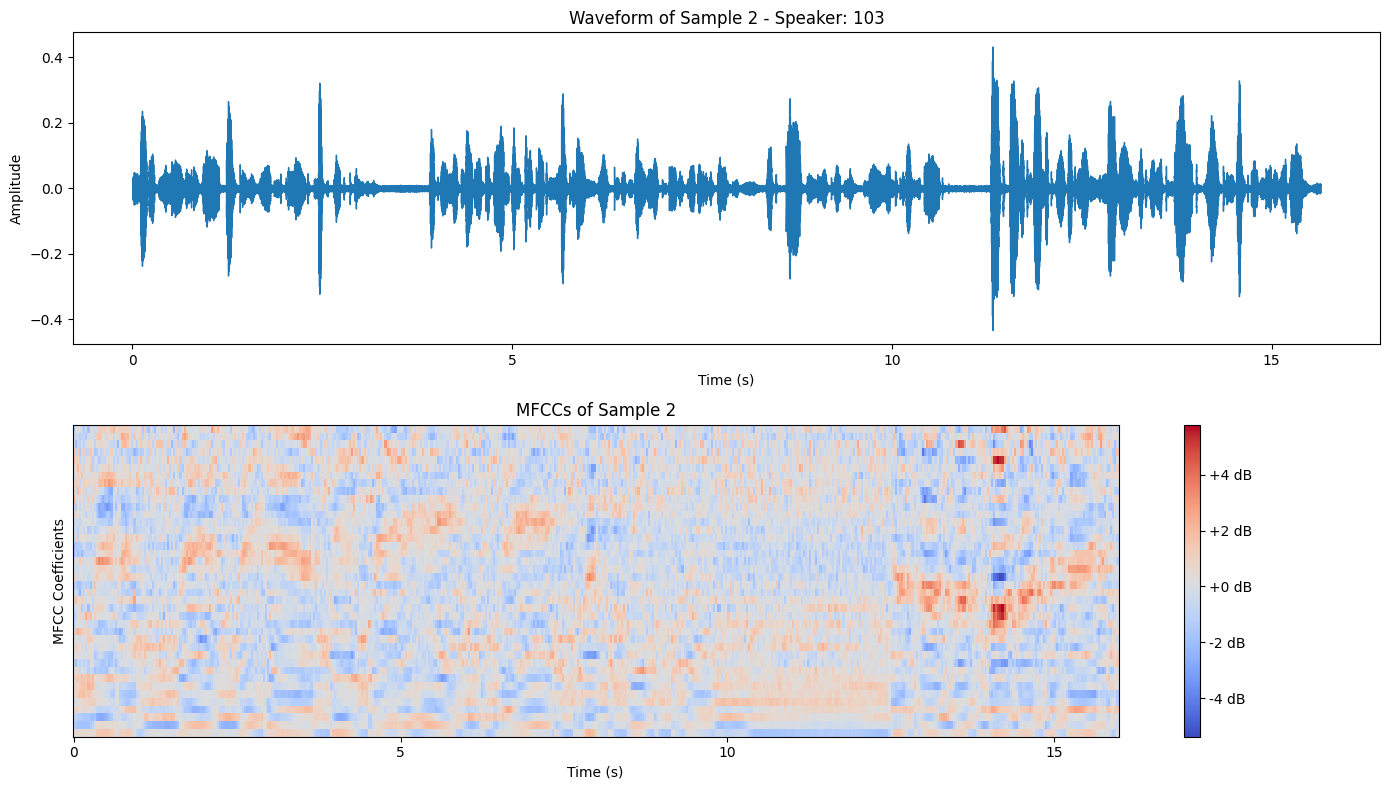

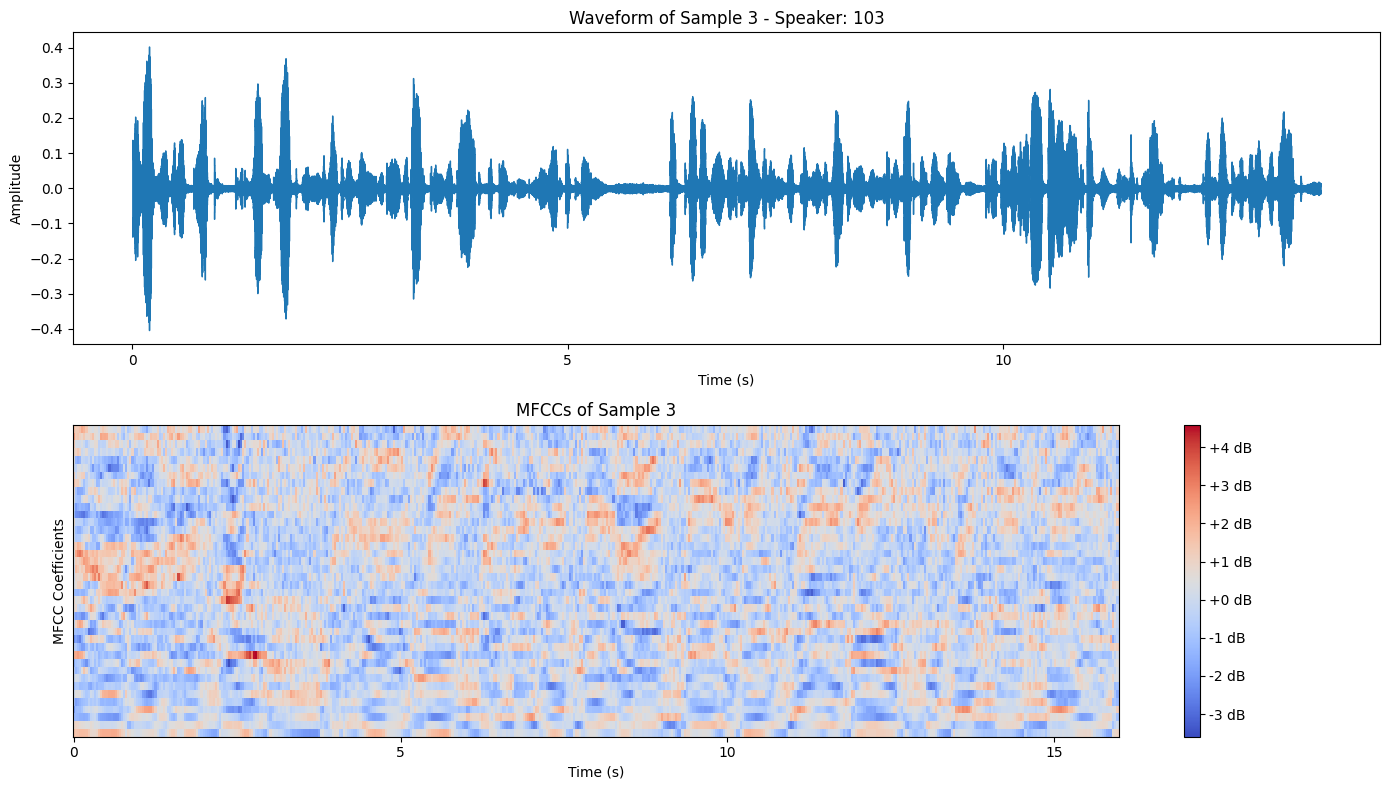

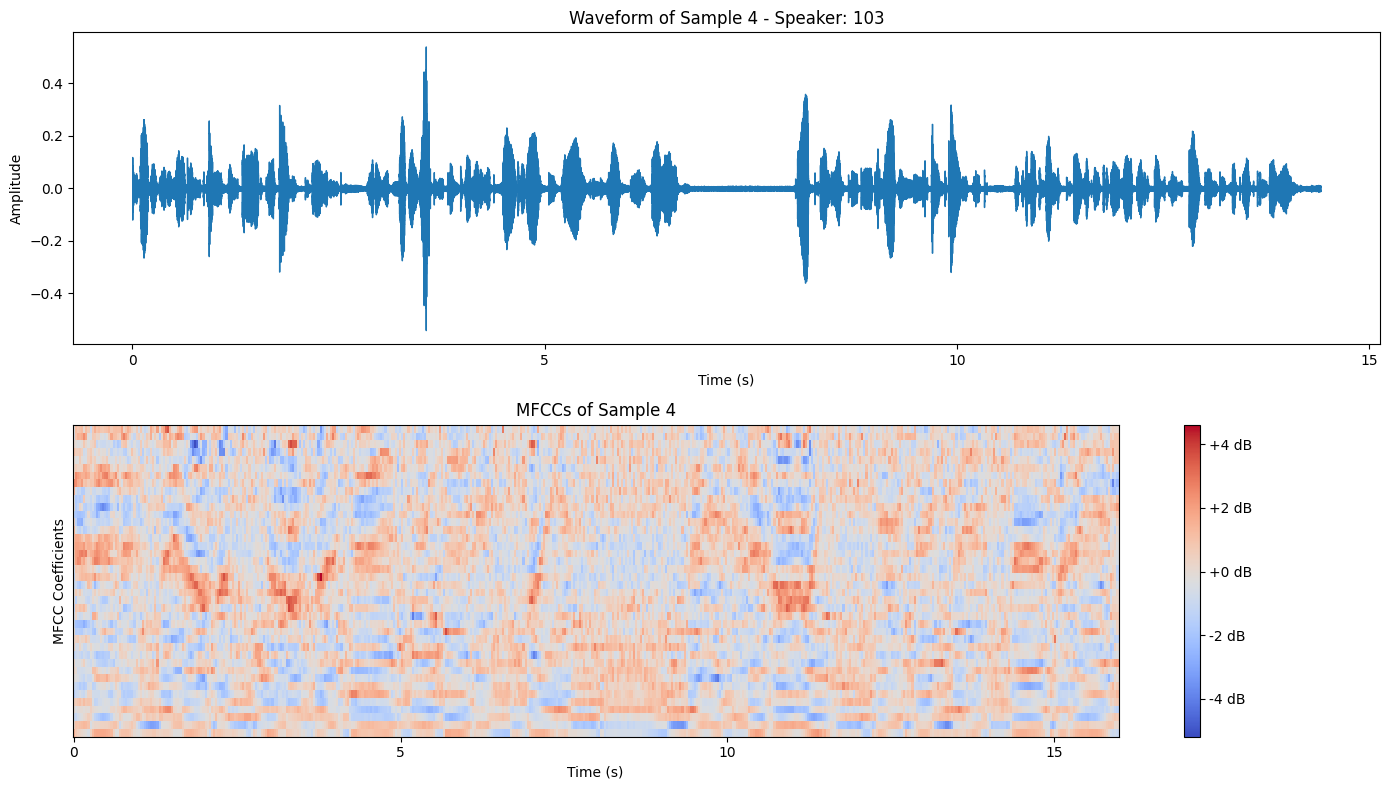

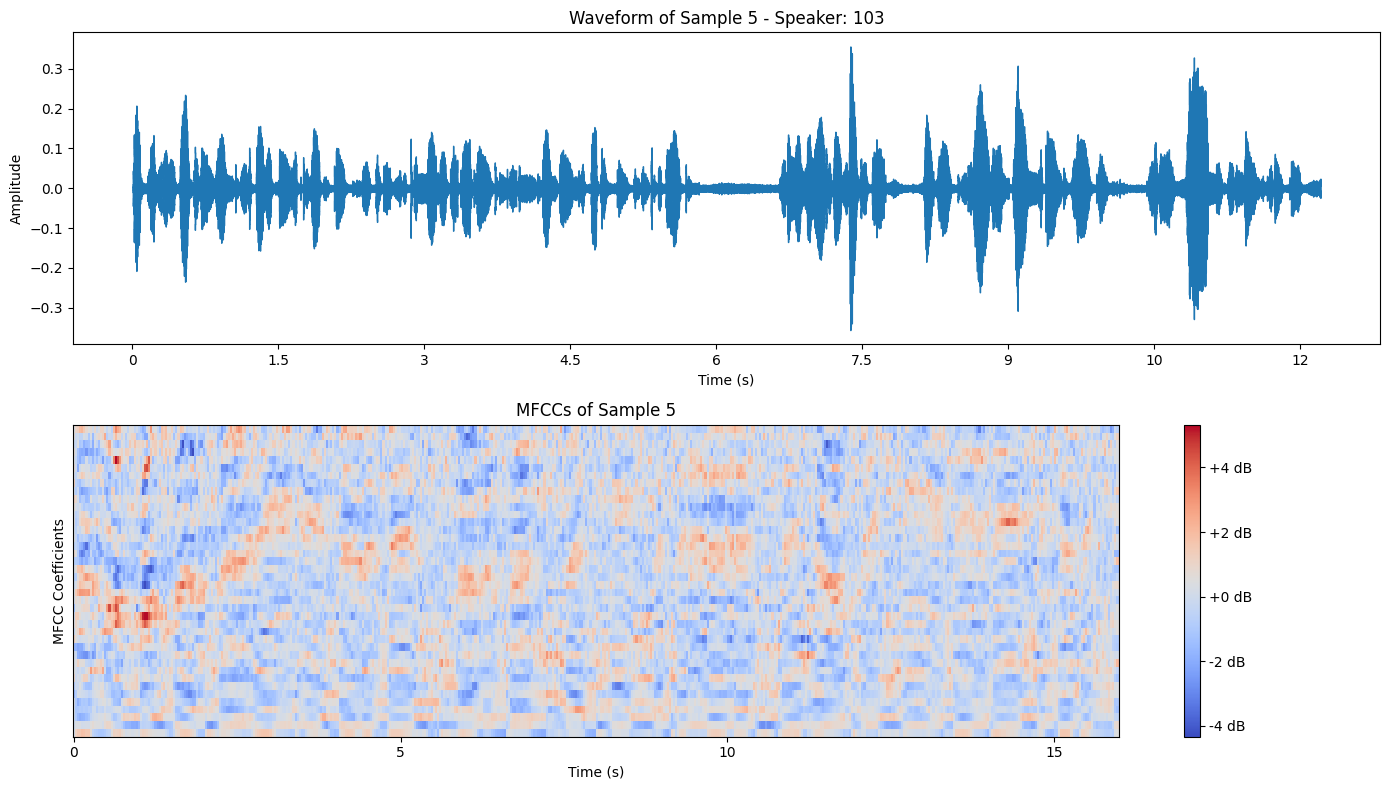

In [ ]:
for i in range(5):
    sample_waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = librispeech_dataset[i]
    preprocessed_waveform = preprocess_waveform(sample_waveform, sample_rate)
    mfcc_features = get_mfcc(preprocessed_waveform)

    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(preprocessed_waveform.numpy(), sr=16000)
    plt.title(f'Waveform of Sample {i+1} - Speaker: {speaker_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfcc_features.numpy(), sr=16000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCCs of Sample {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()


In [ ]:
print(f"Total samples in dataset: {len(librispeech_dataset)}")


Total samples in dataset: 28539


In [ ]:
print(f"Total samples in dataset: {len(librispeech_dataset)}")

from collections import defaultdict
from sklearn.model_selection import train_test_split

TARGET_NUM_SPEAKERS = 50
TARGET_SAMPLES_PER_SPEAKER = 20

speaker_to_indices = defaultdict(list)
for idx, sample in enumerate(librispeech_dataset):
    speaker_id = sample[3]
    speaker_to_indices[speaker_id].append(idx)

eligible_speakers = [speaker_id for speaker_id, indices in speaker_to_indices.items()
                    if len(indices) >= TARGET_SAMPLES_PER_SPEAKER]

print(f"Total eligible speakers (with at least {TARGET_SAMPLES_PER_SPEAKER} samples): {len(eligible_speakers)}")
if len(eligible_speakers) < TARGET_NUM_SPEAKERS:
    raise ValueError(f"Not enough speakers with at least {TARGET_SAMPLES_PER_SPEAKER} samples. "
                     f"Found only {len(eligible_speakers)} eligible speakers.")
selected_speaker_ids = eligible_speakers[:TARGET_NUM_SPEAKERS]

subset_indices = []
for speaker_id in selected_speaker_ids:
    subset_indices.extend(speaker_to_indices[speaker_id][:TARGET_SAMPLES_PER_SPEAKER])

train_subset_indices, val_subset_indices = train_test_split(
    subset_indices, test_size=0.2, random_state=42
)

print(f"Total speakers selected: {len(selected_speaker_ids)}")
print(f"Number of training samples: {len(train_subset_indices)}")
print(f"Number of validation samples: {len(val_subset_indices)}")



Total samples in dataset: 28539
Total eligible speakers (with at least 20 samples): 251
Total speakers selected: 50
Number of training samples: 800
Number of validation samples: 200


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, dataset, indices, transform, augment=False, max_triplets_per_speaker=100):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.augment = augment
        self.max_triplets_per_speaker = max_triplets_per_speaker
        self.triplets = self._generate_triplets()

    def _generate_triplets(self):
        speaker_indices = {}
        for idx in self.indices:
            _, _, _, speaker_id, _, _ = self.dataset[idx]
            if speaker_id not in speaker_indices:
                speaker_indices[speaker_id] = []
            speaker_indices[speaker_id].append(idx)

        triplets = []
        speaker_ids = list(speaker_indices.keys())
        all_indices = self.indices
        for speaker_id in speaker_ids:
            pos_indices = speaker_indices[speaker_id]
            if len(pos_indices) < 2:
                continue
            pos_pairs = list(itertools.combinations(pos_indices, 2))
            random.shuffle(pos_pairs)
            pos_pairs = pos_pairs[:self.max_triplets_per_speaker]
            for idx_anchor, idx_positive in pos_pairs:
                idx_negative = random.choice(all_indices)
                _, _, _, neg_speaker_id, _, _ = self.dataset[idx_negative]
                while neg_speaker_id == speaker_id:
                    idx_negative = random.choice(all_indices)
                    _, _, _, neg_speaker_id, _, _ = self.dataset[idx_negative]
                triplets.append((idx_anchor, idx_positive, idx_negative))
        random.shuffle(triplets)
        return triplets

    def __getitem__(self, idx):
        try:
            idx_anchor, idx_positive, idx_negative = self.triplets[idx]
            waveform_anchor, sample_rate_anchor, _, _, _, _ = self.dataset[idx_anchor]
            waveform_positive, sample_rate_positive, _, _, _, _ = self.dataset[idx_positive]
            waveform_negative, sample_rate_negative, _, _, _, _ = self.dataset[idx_negative]

            if self.augment:
                waveform_anchor = augment_waveform(waveform_anchor, sample_rate_anchor)
                waveform_positive = augment_waveform(waveform_positive, sample_rate_positive)
                waveform_negative = augment_waveform(waveform_negative, sample_rate_negative)
            else:
                waveform_anchor = preprocess_waveform(waveform_anchor, sample_rate_anchor)
                waveform_positive = preprocess_waveform(waveform_positive, sample_rate_positive)
                waveform_negative = preprocess_waveform(waveform_negative, sample_rate_negative)

            if waveform_anchor.size(0) > 1:
                waveform_anchor = waveform_anchor.mean(dim=0, keepdim=True)
            if waveform_positive.size(0) > 1:
                waveform_positive = waveform_positive.mean(dim=0, keepdim=True)
            if waveform_negative.size(0) > 1:
                waveform_negative = waveform_negative.mean(dim=0, keepdim=True)

            if waveform_anchor.size(1) == 0 or waveform_positive.size(1) == 0 or waveform_negative.size(1) == 0:
                print(f"Empty waveform detected in triplet index {idx}. Skipping this triplet.")
                return None, None, None

            anchor = self.transform(waveform_anchor)
            positive = self.transform(waveform_positive)
            negative = self.transform(waveform_negative)

            return anchor, positive, negative
        except Exception as e:
            print(f"Error in __getitem__ for index {idx}: {e}")
            return None, None, None

    def __len__(self):
        return len(self.triplets)




In [ ]:
def collate_fn(batch):
    batch = [triplet for triplet in batch if triplet[0] is not None]
    if not batch:
        return None, None, None

    anchors, positives, negatives = zip(*batch)
    anchors = torch.stack(anchors)
    positives = torch.stack(positives)
    negatives = torch.stack(negatives)
    return anchors, positives, negatives


In [ ]:
class OneShotSiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=256, fixed_length=500):
        super(OneShotSiameseNetwork, self).__init__()
        self.fixed_length = fixed_length
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.fc = nn.Sequential(
            nn.Linear(self._get_flattened_size(), embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def _get_flattened_size(self):
        dummy_input = torch.zeros(1, 1, 40, self.fixed_length)
        x = self.cnn(dummy_input)
        flattened_size = x.numel()
        print(f"Flattened size: {flattened_size}")
        return flattened_size

    def forward_once(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

    def forward(self, anchor, positive, negative):
        anchor_output = self.forward_once(anchor)
        positive_output = self.forward_once(positive)
        negative_output = self.forward_once(negative)
        return anchor_output, positive_output, negative_output

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = F.pairwise_distance(anchor, positive)
        neg_distance = F.pairwise_distance(anchor, negative)
        losses = F.relu(pos_distance - neg_distance + self.margin)
        return losses.mean()


In [ ]:
def train_one_shot_model(model, train_loader, val_loader, num_epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6)
    criterion = TripletLoss(margin=1.0)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    writer = SummaryWriter('runs/voice_authentication_experiment')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (anchor, positive, negative) in enumerate(train_loader):
            if anchor is None:
                continue
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            optimizer.zero_grad()
            anchor_output, positive_output, negative_output = model(anchor, positive, negative)
            loss = criterion(anchor_output, positive_output, negative_output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        writer.add_scalar('Loss/Train', avg_train_loss, epoch)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                if anchor is None:
                    continue
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
                anchor_output, positive_output, negative_output = model(anchor, positive, negative)
                loss = criterion(anchor_output, positive_output, negative_output)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_one_shot_speaker_authentication.pth')
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
    writer.close()
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def evaluate_one_shot_model(model, eval_loader):
    model.eval()
    all_distances, all_labels = [], []
    with torch.no_grad():
        for anchor, positive, negative in eval_loader:
            if anchor is None:
                continue
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_output = model.forward_once(anchor)
            positive_output = model.forward_once(positive)
            negative_output = model.forward_once(negative)

            pos_distance = F.pairwise_distance(anchor_output, positive_output).cpu().numpy()
            neg_distance = F.pairwise_distance(anchor_output, negative_output).cpu().numpy()

            all_distances.extend(pos_distance)
            all_labels.extend(np.ones(len(pos_distance)))

            all_distances.extend(neg_distance)
            all_labels.extend(np.zeros(len(neg_distance)))

    fpr, tpr, thresholds = roc_curve(all_labels, all_distances)
    eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    auc_score = roc_auc_score(all_labels, -np.array(all_distances))

    print(f"Optimal Threshold (EER): {eer_threshold:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}")

    return float(eer_threshold)

def plot_embedding_space(model, eval_loader):
    from sklearn.manifold import TSNE

    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for anchor, positive, negative in eval_loader:
            if anchor is None:
                continue
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_output = model.forward_once(anchor)
            positive_output = model.forward_once(positive)
            negative_output = model.forward_once(negative)

            embeddings.append(anchor_output.cpu().numpy())
            embeddings.append(positive_output.cpu().numpy())
            embeddings.append(negative_output.cpu().numpy())
            labels.extend(['Anchor'] * anchor_output.size(0))
            labels.extend(['Positive'] * positive_output.size(0))
            labels.extend(['Negative'] * negative_output.size(0))

    embeddings = np.concatenate(embeddings, axis=0)
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette='deep')
    plt.title('t-SNE Visualization of Embedding Space')
    plt.legend()
    plt.show()

def test_model_with_samples(model, dataset, optimal_threshold):
    model.eval()
    speakers = [speaker_id for speaker_id in set([librispeech_dataset[i][3] for i in dataset.indices])]
    random_speaker_id = random.choice(speakers)
    same_speaker_indices = [idx for idx in dataset.indices if librispeech_dataset[idx][3] == random_speaker_id]

    if len(same_speaker_indices) < 2:
        print("Not enough samples from the same speaker.")
        return
    same_speaker_indices = random.sample(same_speaker_indices, 2)

    different_speaker_indices = [idx for idx in dataset.indices if librispeech_dataset[idx][3] != random_speaker_id]
    if len(different_speaker_indices) == 0:
        print("No samples from different speakers.")
        return
    different_speaker_idx = random.choice(different_speaker_indices)

    waveform1, sample_rate1, _, _, _, _ = librispeech_dataset[different_speaker_idx]
    waveform2, sample_rate2, _, _, _, _ = librispeech_dataset[same_speaker_indices[0]]
    waveform3, sample_rate3, _, _, _, _ = librispeech_dataset[same_speaker_indices[1]]

    waveform2 = preprocess_waveform(waveform2, sample_rate2)
    waveform3 = preprocess_waveform(waveform3, sample_rate3)
    waveform1 = preprocess_waveform(waveform1, sample_rate1)

    sample2 = get_mfcc(waveform2).to(device)
    sample3 = get_mfcc(waveform3).to(device)
    sample1 = get_mfcc(waveform1).to(device)

    with torch.no_grad():
        output2 = model.forward_once(sample2.unsqueeze(0))
        output3 = model.forward_once(sample3.unsqueeze(0))
        output1 = model.forward_once(sample1.unsqueeze(0))

        distance_same = F.pairwise_distance(output2, output3).item()
        distance_diff = F.pairwise_distance(output2, output1).item()

        similarity_same = -distance_same
        similarity_diff = -distance_diff

        print(f"Similarity score between same speaker samples: {similarity_same:.4f}")
        print(f"Similarity score between different speaker samples: {similarity_diff:.4f}")
        print(f"Using Threshold: {optimal_threshold:.4f}")
        print(f"Same speaker similarity > threshold: {similarity_same > optimal_threshold}")
        print(f"Different speaker similarity > threshold: {similarity_diff > optimal_threshold}")

    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 1)
    librosa.display.specshow(sample1.cpu().numpy(), sr=16000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs of Sample 1 (Different Speaker)')

    plt.subplot(3, 1, 2)
    librosa.display.specshow(sample2.cpu().numpy(), sr=16000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs of Sample 2 (Same Speaker)')

    plt.subplot(3, 1, 3)
    librosa.display.specshow(sample3.cpu().numpy(), sr=16000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs of Sample 3 (Same Speaker)')

    plt.tight_layout()
    plt.show()

def evaluate_model_with_metrics(model, eval_loader, threshold, suppress_output=False):
    if threshold is None:
        raise ValueError("Threshold must be provided for metric evaluation.")

    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for anchor, positive, negative in eval_loader:
            if anchor is None:
                continue
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_output = model.forward_once(anchor)
            positive_output = model.forward_once(positive)
            negative_output = model.forward_once(negative)

            pos_distance = F.pairwise_distance(anchor_output, positive_output).cpu().numpy()
            neg_distance = F.pairwise_distance(anchor_output, negative_output).cpu().numpy()

            all_labels.extend([1] * len(pos_distance))
            all_predictions.extend([1 if dist < threshold else 0 for dist in pos_distance])

            all_labels.extend([0] * len(neg_distance))
            all_predictions.extend([1 if dist < threshold else 0 for dist in neg_distance])

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    if not suppress_output:
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1

def plot_similarity_distributions(model, eval_loader, optimal_threshold):
    model.eval()
    positive_scores = []
    negative_scores = []

    with torch.no_grad():
        for anchor, positive, negative in eval_loader:
            if anchor is None:
                continue
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            anchor_output = model.forward_once(anchor)
            positive_output = model.forward_once(positive)
            negative_output = model.forward_once(negative)

            pos_distance = F.pairwise_distance(anchor_output, positive_output).cpu().numpy()
            neg_distance = F.pairwise_distance(anchor_output, negative_output).cpu().numpy()

            positive_scores.extend(-pos_distance)
            negative_scores.extend(-neg_distance)

    plt.figure(figsize=(10, 6))
    sns.histplot(positive_scores, kde=True, color="green", label="Same Speaker", bins=30)
    sns.histplot(negative_scores, kde=True, color="red", label="Different Speaker", bins=30)
    plt.axvline(x=optimal_threshold, color="blue", linestyle="--", label="Threshold")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Similarity Score Distributions")
    plt.legend()
    plt.show()



In [ ]:
import multiprocessing
from torch.utils.data import DataLoader

batch_size = 16
num_workers = multiprocessing.cpu_count()

train_dataset = TripletDataset(
    dataset=librispeech_dataset,
    indices=train_subset_indices,
    transform=lambda waveform: get_mfcc(waveform, fixed_length=500),
    augment=True
)

val_dataset = TripletDataset(
    dataset=librispeech_dataset,
    indices=val_subset_indices,
    transform=lambda waveform: get_mfcc(waveform, fixed_length=500),
    augment=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")



Number of training batches: 301
Number of validation batches: 24


In [ ]:
try:
    anchor_batch, positive_batch, negative_batch = next(iter(train_loader))
    if anchor_batch is not None:
        print(f"Anchor batch shape: {anchor_batch.shape}")
        print(f"Positive batch shape: {positive_batch.shape}")
        print(f"Negative batch shape: {negative_batch.shape}")
    else:
        print("Sample batch is None. Check data preprocessing.")
except Exception as e:
    print(f"Error fetching a batch: {e}")



Applying effects: ['speed', '0.94']Applying effects: ['pitch', '38.7']

Augmentation failed: Unsupported effect: p
Augmentation failed: Unsupported effect: s
Applying effects: ['pitch', '34.93']Applying effects: ['speed', '0.93', 'pitch', '-38.11']

Augmentation failed: Unsupported effect: sAugmentation failed: Unsupported effect: p

Applying effects: ['speed', '0.95', 'reverb']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.93', 'reverb']
Applying effects: ['speed', '1.07', 'pitch', '12.4', 'reverb']
Augmentation failed: Unsupported effect: s
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.95', 'reverb']Applying effects: ['pitch', '26.63']

Augmentation failed: Unsupported effect: pAugmentation failed: Unsupported effect: s

Applying effects: ['speed', '1.09', 'reverb']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.96', 'pitch', '13.66']
Augmentation failed: Unsupported effect: s
Applying effects: ['rever

Streaming output truncated to the last 5000 lines.
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.95', 'pitch', '-11.68']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.98']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '0.98']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '1.08', 'pitch', '26.25', 'reverb']
Augmentation failed: Unsupported effect: s
Applying effects: ['reverb']
Augmentation failed: Unsupported effect: r
Applying effects: ['speed', '0.93']
Augmentation failed: Unsupported effect: s
Applying effects: ['speed', '1.06', 'pitch', '6.36', 'reverb']
Augmentation failed: Unsupported effect: s
Applying effects: ['pitch', '21.45', 'reverb']
Augmentation failed: Unsupported effect: p
Applying effects: ['speed', '1.03', 'pitch', '40.53', 'reverb']
Augmentation failed: Unsupported effect: s
Applying effects: ['pitch', '-5.75', 'reverb']
Augmentation failed: Unsupported effect: p

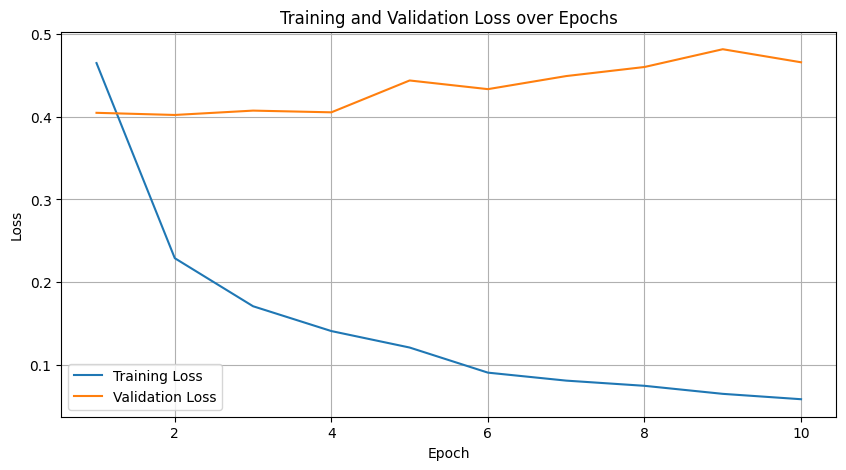

In [ ]:
model = OneShotSiameseNetwork(fixed_length=500).to(device)
print("Model instantiated with fixed_length=500")
flattened_size = model._get_flattened_size()

train_one_shot_model(model, train_loader, val_loader, num_epochs=10)


In [ ]:
model.load_state_dict(torch.load('best_one_shot_speaker_authentication.pth'))
model.to(device)
print("Loaded the best model.")

optimal_threshold = evaluate_one_shot_model(model, val_loader)
plot_embedding_space(model, val_loader)
accuracy, precision, recall, f1 = evaluate_model_with_metrics(model, val_loader, optimal_threshold)
plot_similarity_distributions(model, val_loader, optimal_threshold)




In [ ]:
def enroll_user(model, enrollment_audio_path):
    waveform, sample_rate = torchaudio.load(enrollment_audio_path)
    preprocessed_waveform = preprocess_waveform(waveform, sample_rate)
    mfcc = get_mfcc(preprocessed_waveform).to(device)
    with torch.no_grad():
        embedding = model.forward_once(mfcc.unsqueeze(0))
    return embedding.cpu()

def verify_user(model, stored_embedding, verification_audio_path, threshold):
    waveform, sample_rate = torchaudio.load(verification_audio_path)
    preprocessed_waveform = preprocess_waveform(waveform, sample_rate)
    mfcc = get_mfcc(preprocessed_waveform).to(device)
    with torch.no_grad():
        current_embedding = model.forward_once(mfcc.unsqueeze(0))
    distance = F.pairwise_distance(stored_embedding, current_embedding).item()
    similarity_score = -distance
    is_authenticated = similarity_score > threshold
    return is_authenticated, similarity_score

# Enrollment: Process and store the user's embedding from the enrollment audio
stored_embedding = enroll_user(model, '/content/enrollment_audio.wav')

# Verification: Compare a new verification audio against the stored embedding
is_authenticated, score = verify_user(model, stored_embedding, '/content/verification_audio.wav', optimal_threshold)

# Display the results
print(f"Authenticated: {is_authenticated}, Similarity Score: {score:.4f}")

